## Table of Contents:
1. Overview of Dataset
2. Expoloratory Analysis
3. Modeling
4. Summary

### 1. Overview of  Dataset

In [1]:
import pandas  as pd
import numpy  as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_csv('/Users/naokoshi/Desktop/Stripe.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# 6362620 rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [15]:
# check nulls, and there's all unnull values, good
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
# within 743 hour, in one month
print(min(df['step']))
print(max(df['step']))

1
743


In [12]:
# the most frequent one is cash-out
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [155]:
# 16 illegal flagged fraud
len(df[df['isFlaggedFraud']==1])

16

In [157]:
# 8213,  0.13% of entire records are frauds
len(df[df['isFraud']==1])

8213

### 2. Exploratory Analysis



In [41]:
# create "day" based on "step"
start=0
binss=[]
while start<=743:
    binss.append(start)
    start+=24
binss.append(743)
print(binss)
df['Day']=pd.cut(df['step'], bins=binss, right=True, labels=False )+1

[0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600, 624, 648, 672, 696, 720, 743]


In [42]:
# create "week" baed on "step"
start=0
binss=[]
while start<=743:
    binss.append(start)
    start+=24*7
binss.append(743)
print(binss)
df['Week']=pd.cut(df['step'], bins=binss, right=True, labels=False )+1

[0, 168, 336, 504, 672, 743]


#### 1. Check daily/weekly trand of number of frauds and transactions

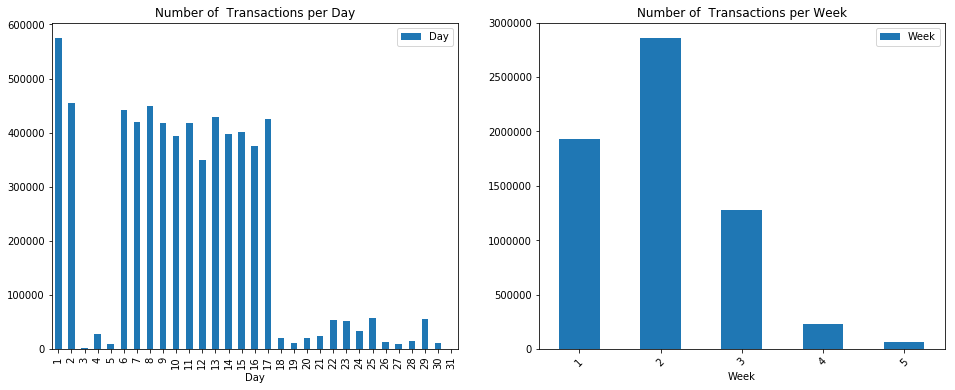

In [188]:
# check daily/weekly number of  transactions
fig, axes=plt.subplots(1,2, figsize=[16,6])

df.groupby('Day').agg({'Day':'count'}).\
plot(kind='bar', ax=axes[0])
axes[0].set_title('Number of  Transactions per Day')
plt.xticks(rotation=45)

df.groupby('Week').agg({'Week':'count'}).\
plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of  Transactions per Week')
plt.xticks(rotation=45)

plt.show()

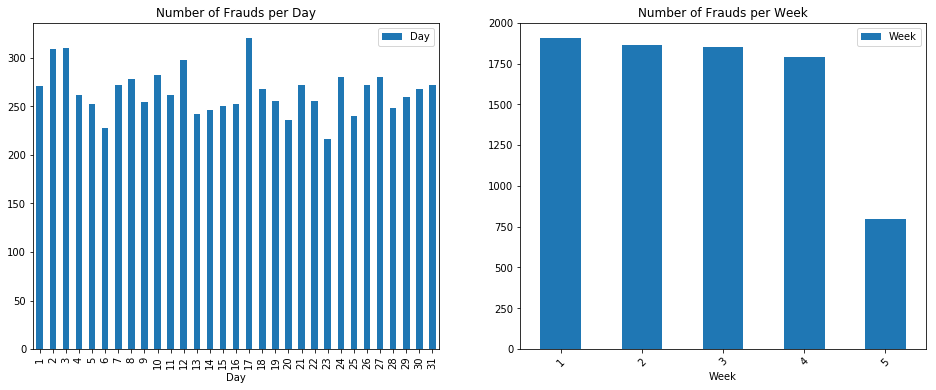

In [189]:
# check number of frauds per day/week
fig, axes=plt.subplots(1,2, figsize=[16,6])

df[df['isFraud']==1].groupby('Day').agg({'Day':'count'}).\
plot(kind='bar', ax=axes[0])
axes[0].set_title('Number of Frauds per Day')
plt.xticks(rotation=45)

df[df['isFraud']==1].groupby('Week').agg({'Week':'count'}).\
plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Frauds per Week')
plt.xticks(rotation=45)

plt.show()

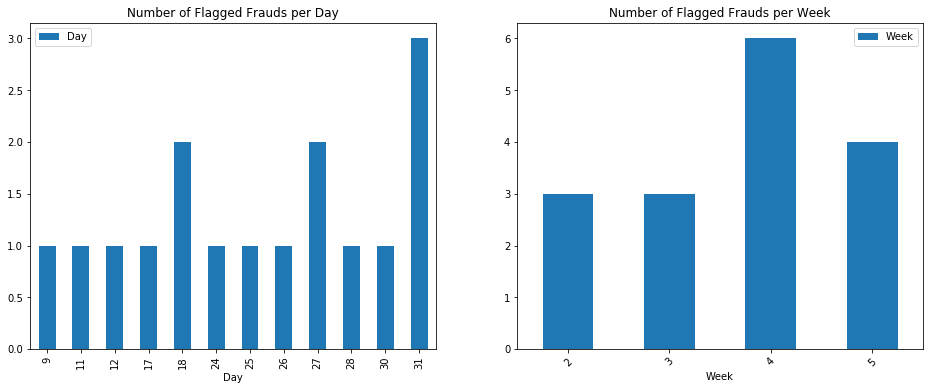

In [197]:
# check number of flagged frauds per day/week
fig, axes=plt.subplots(1,2, figsize=[16,6])

df[df['isFlaggedFraud']==1].groupby('Day').agg({'Day':'count'}).\
plot(kind='bar', ax=axes[0])
axes[0].set_title('Number of Flagged Frauds per Day')
plt.xticks(rotation=45)

df[df['isFlaggedFraud']==1].groupby('Week').agg({'Week':'count'}).\
plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Flagged Frauds per Week')
plt.xticks(rotation=45)

plt.show()

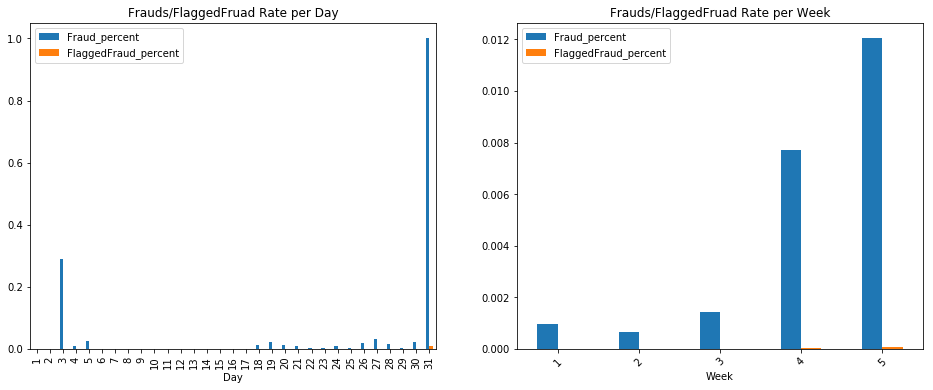

In [200]:
# check fraud/flaggedfrauds rate 
fig, axes=plt.subplots(1,2, figsize=[16,6])

group=df.groupby('Day').agg({'Day':'count', 'isFraud':'sum', 'isFlaggedFraud':'sum'})
group['Fraud_percent']=group['isFraud']/group['Day']
group['FlaggedFraud_percent']=group['isFlaggedFraud']/group['Day']
group[['Fraud_percent', 'FlaggedFraud_percent']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Frauds/FlaggedFruad Rate per Day')
plt.xticks(rotation=45)

group2=df.groupby('Week').agg({'Day':'count', 'isFraud':'sum', 'isFlaggedFraud':'sum'})
group2['Fraud_percent']=group2['isFraud']/group2['Day']
group2['FlaggedFraud_percent']=group2['isFlaggedFraud']/group2['Day']
group2[['Fraud_percent','FlaggedFraud_percent']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Frauds/FlaggedFruad Rate per Week')
plt.xticks(rotation=45)

plt.show()

Within this month, very begining and the second week got much larger number of transactions,  more frauds happened on the first four weeks, most of flagged frauds happen the last two weeks.
Last two weeks have higher percentage of frauds rate(frauds/total transactions). On the last day, almost all the transactions are frauds. 
Basically, the total number of transactions  is trending down but the fraud rate is trending up.

####  2. check daily/weekly trend of total/average amount in local currency for transactions and frauds

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

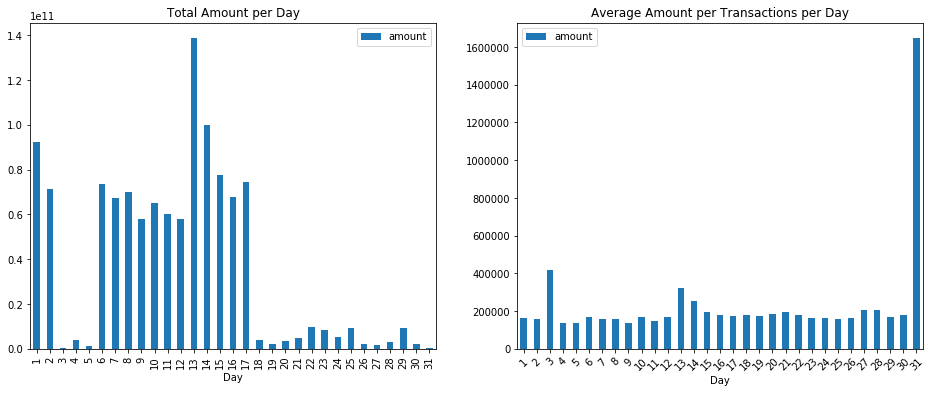

In [195]:
# Check total amount in local currency and average amount per transaction per day
fig, axes=plt.subplots(1,2, figsize=[16,6])

df.groupby('Day').agg({'amount':'sum'}).\
plot(kind='bar', ax=axes[0])
axes[0].set_title('Total Amount per Day')
plt.xticks(rotation=45)

df.groupby('Day').agg({'amount':'mean'}).\
plot(kind='bar',ax=axes[1])
axes[1].set_title('Average Amount per Transactions per Day')
plt.xticks(rotation=45)

check frauds on the last day since its average amount of transactions is very huge while
the total number of transactions is not that much.


In [330]:
print('Total number of Transaction is{}'.format(len(df[df['Day']==31])))
print('Number of Frauds is{}'.format(df[df['Day']==31].groupby('isFraud')['isFraud'].count()))
print('Average Amount($) of Frauds are {}'.format(df[df['Day']==31]['amount'].mean()))

Total number of Transaction is272
Number of Frauds isisFraud
1    272
Name: isFraud, dtype: int64
Average Amount($) of Frauds are 1647375.863382352


In [327]:
print(df[df['Day']==31].groupby('isFlaggedFraud')['isFraud'].count())

isFlaggedFraud
0    269
1      3
Name: isFraud, dtype: int64


In [171]:
df[df['Day']==31]['nameDest'].value_counts().sort_values()

C112833674     1
C1924072555    1
C500987951     1
C1469754483    1
C1406817938    1
              ..
C1023330867    1
C2099952089    1
C1850423904    1
C1366804249    1
C2077145577    1
Name: nameDest, Length: 272, dtype: int64

It's strange that all the 272 transactions are frauds. I think, first we need to check if the data is accurate or data logging process got wrong. Second, we can check if those frauds happening in any certain type of device(android/ios) and country/city, to see if there's any hacker attach or technical issue happening on certain device or region.

In [209]:
a=df.groupby('Week').agg({'amount':[('1','sum'), ('2','mean')], 'Week':'count'})
a['mean']=a.iloc[:,0]/a.iloc[:,2]
a

amount                    Week           mean
                 1              2    count               
Week                                                     
1     3.094540e+11  160323.927120  1930180  160323.927120
2     5.503163e+11  192782.620529  2854595  192782.620529
3     2.336983e+11  182682.237256  1279261  182682.237256
4     3.912272e+10  168534.334999   232135  168534.334999
5     1.180162e+10  177604.224188    66449  177604.224188

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

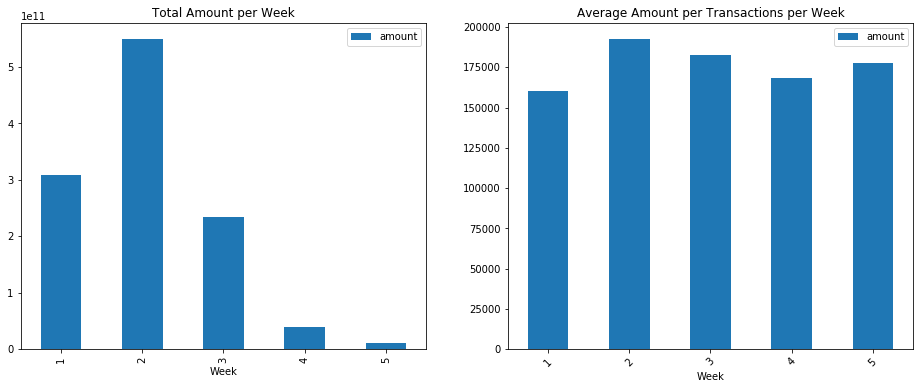

In [201]:
# Check total amount in local currency and average amount per transaction per week
fig, axes=plt.subplots(1,2, figsize=[16,6])

df.groupby('Week').agg({'amount':'sum'}).\
plot(kind='bar', ax=axes[0])
axes[0].set_title('Total Amount per Week')
plt.xticks(rotation=45)

df.groupby('Week').agg({'amount':'mean'}).\
plot(kind='bar',ax=axes[1])
axes[1].set_title('Average Amount per Transactions per Week')
plt.xticks(rotation=45)

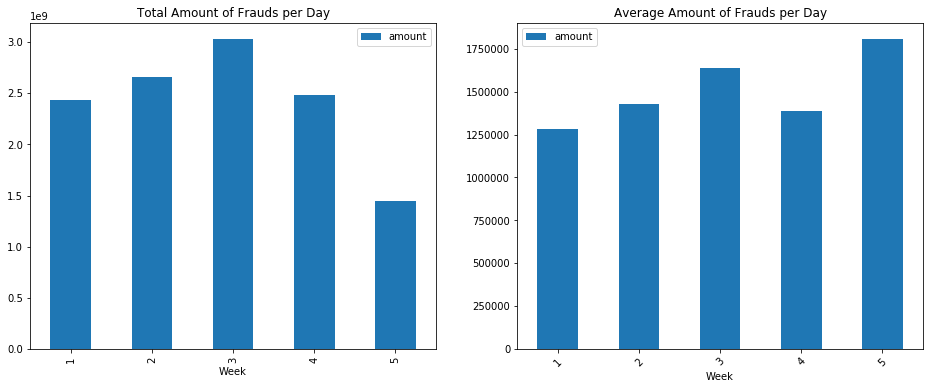

In [214]:
# check weekly total amount and average amount per transaction for Frauds 
fig, axes=plt.subplots(1,2, figsize=[16,6])

df[df['isFraud']==1].groupby('Week').agg({'amount':'sum'}).\
plot(kind='bar', ax=axes[0])
axes[0].set_title('Total Amount of Frauds per Day')
plt.xticks(rotation=45)

df[df['isFraud']==1].groupby('Week').agg({'amount':'mean'}).\
plot(kind='bar',ax=axes[1])
axes[1].set_title('Average Amount of Frauds per Day')
plt.xticks(rotation=45)

plt.show()

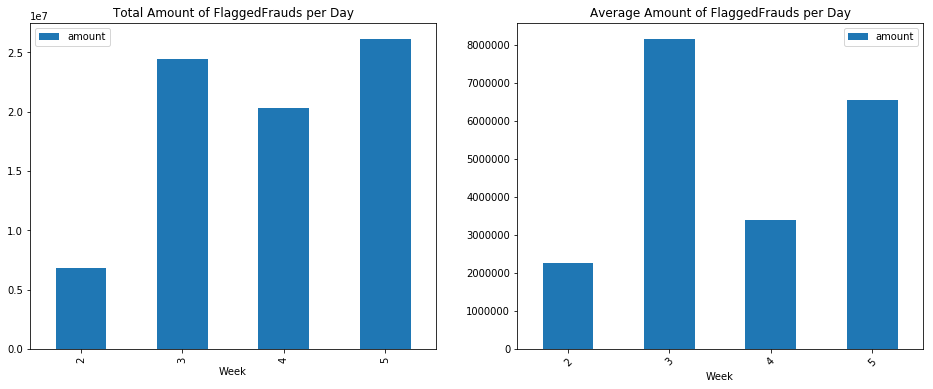

In [215]:
# check weekly total amount and average amount per transaction for FlaggedFrauds 
fig, axes=plt.subplots(1,2, figsize=[16,6])

df[df['isFlaggedFraud']==1].groupby('Week').agg({'amount':'sum'}).\
plot(kind='bar', ax=axes[0])
axes[0].set_title('Total Amount of FlaggedFrauds per Day')
plt.xticks(rotation=45)

df[df['isFlaggedFraud']==1].groupby('Week').agg({'amount':'mean'}).\
plot(kind='bar',ax=axes[1])
axes[1].set_title('Average Amount of FlaggedFrauds per Day')
plt.xticks(rotation=45)

plt.show()

#### 3. Time series analysis considering type  of transactions

Text(0.5,1,'Weekly Total Number of Transactions by Each Type')

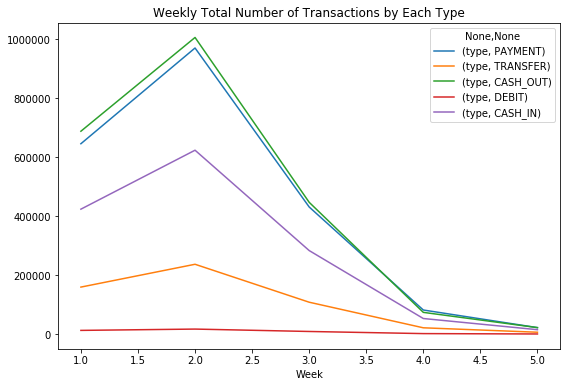

In [217]:
fig, ax = plt.subplots()

for i in df['type'].unique():
    df[df['type']==i].groupby('Week').agg({'type':[(i, 'count')]}).plot(ax=ax,figsize=[9,6])
plt.title('Weekly Total Number of Transactions by Each Type')

Text(0.5,1,'Weekly Total Amount of Transactions by Each Type')

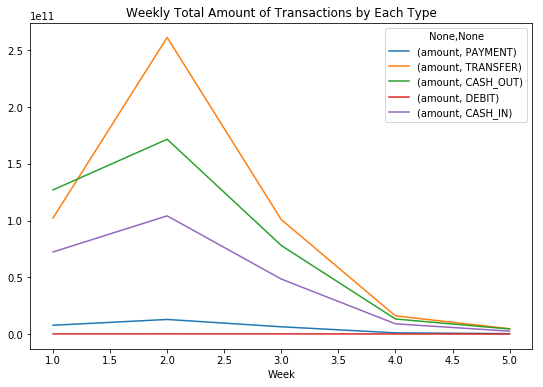

In [103]:
fig, ax = plt.subplots()

for i in df['type'].unique():
    df[df['type']==i].groupby('Week').agg({'amount':[(i, 'sum')]}).plot(ax=ax,figsize=[9,6])

plt.title('Weekly Total Amount of Transactions by Each Type')

cash-out and payment are the two most frequent type, cash-out and transfer  are the two types which got the greatest amount. 

Text(0.5,1,'Weekly Total Amount(in local currency) of Frauds by Each Type')

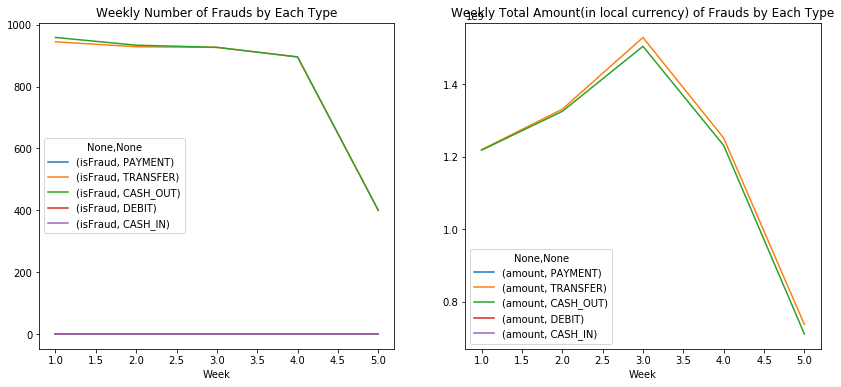

In [324]:
fig, axes = plt.subplots(1,2,figsize=[14,6])

for i in df['type'].unique():
    df[df['type']==i].groupby('Week').agg({'isFraud':[(i, 'sum')]}).plot(ax=axes[0])

axes[0].set_title('Weekly Number of Frauds by Each Type')

for i in df['type'].unique():
    df[(df['type']==i) & (df['isFraud']==1)].groupby('Week').agg({'amount':[(i,'sum')]}).plot(ax=axes[1])

axes[1].set_title('Weekly Total Amount(in local currency) of Frauds by Each Type')

Text(0.5,1,'Weekly Amount of Flagged Frauds by Each Type')

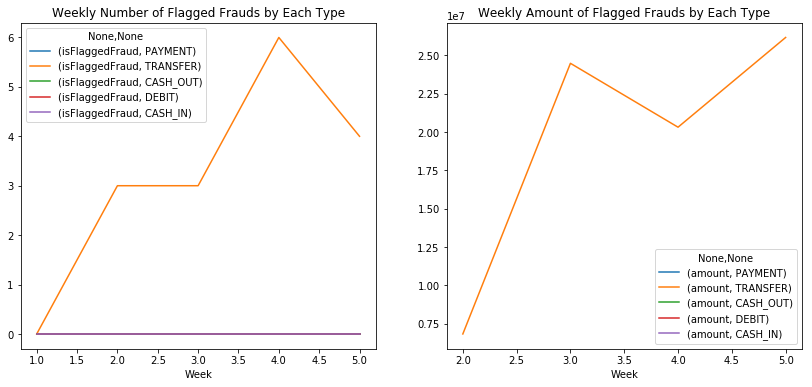

In [246]:
fig, axes = plt.subplots(1,2,figsize=[14,6])

for i in df['type'].unique():
    df[df['type']==i].groupby('Week').agg({'isFlaggedFraud':[(i, 'sum')]}).plot(ax=axes[0])

axes[0].set_title('Weekly Number of Flagged Frauds by Each Type')

for i in df['type'].unique():
    df[(df['type']==i) & (df['isFlaggedFraud']==1)].groupby('Week').agg({'amount':[(i,'sum')]}).plot(ax=axes[1])

axes[1].set_title('Weekly Amount of Flagged Frauds by Each Type')

In [245]:
group=df[(df['type']=='CASH_OUT')].groupby(['Week','type']).agg({'type':'count',\
                                       'isFraud':'sum', 'isFlaggedFraud':'sum'})
group['fraud_rate']=group['isFraud']/group['type'].round(4)
group['flaggedfraud_rate']=group['isFlaggedFraud']/group['type'].round(4)
group[['fraud_rate', 'flaggedfraud_rate']]
# plt.xticks(rotation=45)

,,fraud_rate,flaggedfraud_rate
Week,type,,
1,CASH_OUT,0.001393,0.0
2,CASH_OUT,0.000928,0.0
3,CASH_OUT,0.002073,0.0
4,CASH_OUT,0.012129,0.0
5,CASH_OUT,0.018060,0.0


In [244]:
group=df[(df['type']=='TRANSFER')].groupby(['Week','type']).agg({'type':'count',\
                                       'isFraud':'sum', 'isFlaggedFraud':'sum'})
group['fraud_rate']=group['isFraud']/group['type'].round(4)
group['flaggedfraud_rate']=group['isFlaggedFraud']/group['type'].round(4)
group[['fraud_rate', 'flaggedfraud_rate']]
# plt.xticks(rotation=45)

,,fraud_rate,flaggedfraud_rate
Week,type,,
1,TRANSFER,0.005921,0.000000
2,TRANSFER,0.003920,0.000013
3,TRANSFER,0.008559,0.000028
4,TRANSFER,0.041618,0.000279
5,TRANSFER,0.061557,0.000616


Transfer and cash-out have around 900 times of frauds each week and the number of frauds is trending down week by week. Only transfer has several illegal frauds flagged each week.

Fraud rate(number of frauds/number of transactions) of Transfer is more than 4 times fraud rate of cash-out, and their fraud rate all went up in this month, same trend for flagge!

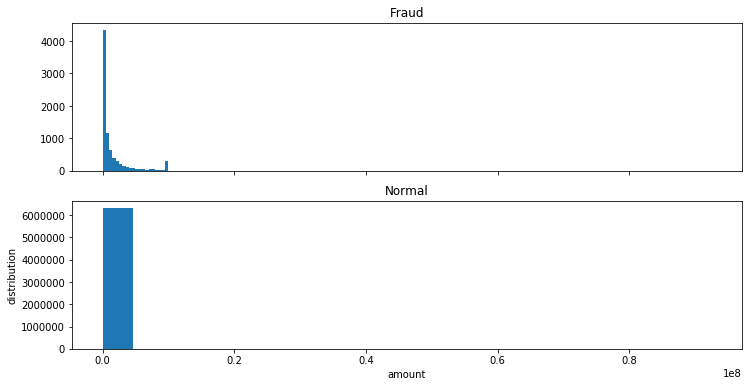

In [144]:
# compare the amount btw fraud and normal transactions
fraud=df[df['isFraud']==1]
normal=df[df['isFraud']==0]

fig, axes=plt.subplots(2,1, figsize=[12,6], sharex=True)
bins=20
axes[0].hist(fraud.amount, bins=bins)
axes[0].set_title('Fraud')
axes[1].hist(normal.amount, bins=bins)
axes[1].set_title('Normal')
# axes[1].yscale('log')

plt.xlabel('amount')
plt.ylabel('distribution')
plt.show()


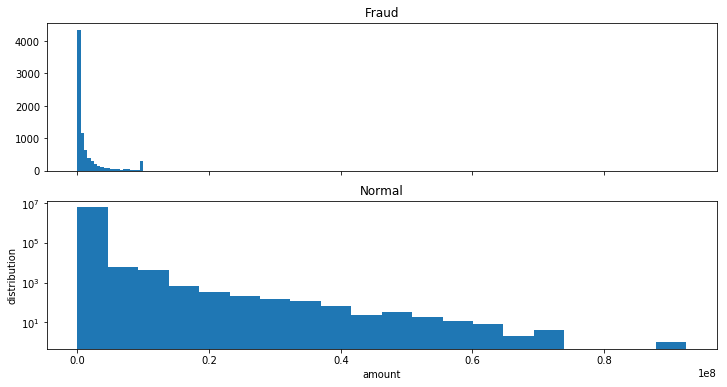

In [145]:
# check using scaling data
fraud=df[df['isFraud']==1]
normal=df[df['isFraud']==0]

fig, axes=plt.subplots(2,1, figsize=[12,6], sharex=True)
bins=20
axes[0].hist(fraud.amount, bins=bins)
axes[0].set_title('Fraud')
axes[1].hist(normal.amount, bins=bins)
axes[1].set_title('Normal')
# axes[1].yscale('log')

plt.yscale('log')
plt.xlabel('amount')
plt.ylabel('distribution')
plt.show()

most of the amount is distributed in a small number.

In [247]:
df.groupby('isFraud')['amount'].mean()
# the average of amount for fraud is about 10 times greater than the normal transaction

isFraud
0    1.781970e+05
1    1.467967e+06
Name: amount, dtype: float64

In [148]:
df[df['isFlaggedFraud']==1]['amount'].mean()
# the average of amount for illegal fraud is about 30 times than the normal transaction

4861597.730625

In [325]:
df.groupby(['type', 'isFraud']).agg({'amount': [('total amount','sum'),\
('average amount per fraud transaction','mean'), ('total number of fraud', 'count')] })

amount                                       \
                  total amount average amount per fraud transaction   
type     isFraud                                                      
CASH_IN  0        2.363674e+11                         1.689202e+05   
CASH_OUT 0        3.884238e+11                         1.739172e+05   
         1        5.989202e+09                         1.455103e+06   
DEBIT    0        2.271992e+08                         5.483665e+03   
PAYMENT  0        2.809337e+10                         1.305760e+04   
TRANSFER 0        4.792248e+11                         9.062290e+05   
         1        6.067213e+09                         1.480892e+06   

                                        
                 total number of fraud  
type     isFraud                        
CASH_IN  0                     1399284  
CASH_OUT 0                     2233384  
         1                        4116  
DEBIT    0                       41432  
PAYMENT  0                     2151495  
TRANSFER 0                      528812  
         1                        4097

Although fraud is only a small part among all the transactions, its average amount per transaction is very huge, which is about 10 times of  the normal transaction, and the average of amount for illegal fraud is about 30 times the normal transaction. 

#### 4. Analysis on NameDest

In [317]:
df['nameOrig'].apply(lambda x: x[0]).unique()

array(['C'], dtype=object)

In [254]:
df['nameDest_new'] = df['nameDest'].apply(lambda x: x[0])

In [255]:
df.groupby('nameDest_new').agg({'isFraud':'sum', 'isFlaggedFraud':'sum'})

,isFraud,isFlaggedFraud
nameDest_new,,
C,8213,16
M,0,0


In [258]:
# all frauds comes from customer recipient. 

### 3.  Modeling 

In [248]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Day,Week
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1


In [275]:
df2=df.copy()

In [276]:
df2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Day,Week,nameDest_new
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1,M
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1,M
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,C
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,C
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1,M


In [277]:
# handeling categorical data
new=pd.get_dummies(df2['type'])
df2=pd.concat([df2, new], axis=1).drop('type',  axis=1)

# create new columns to check if if orig and dest are customer or merchants
df2['OrigC']=df2['nameOrig'].apply(lambda x: 1 if str(x).find('C')==0 else 0)
df2['DestC']=df2['nameDest'].apply(lambda x: 1 if str(x).find('C')==0 else 0)

df2.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Day,Week,nameDest_new,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,OrigC,DestC
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1,M,0,0,0,1,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1,M,0,0,0,1,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,C,0,0,0,0,1,1,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,C,0,1,0,0,0,1,1
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1,M,0,0,0,1,0,1,0


In [280]:
from sklearn.preprocessing import LabelBinarizer
def encoder(col):
    enc=LabelBinarizer()
    df2[col]=enc.fit_transform(df2[col])
    
features=['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'OrigC', 'DestC', 'isFraud']
for i in features:
    encoder(i)
    
df2.head() 

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Day,Week,nameDest_new,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,OrigC,DestC
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1,M,0,0,0,1,0,0,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1,M,0,0,0,1,0,0,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,C,0,0,0,0,1,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,C,0,1,0,0,0,0,1
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1,M,0,0,0,1,0,0,0


In [284]:
# df2.columns
features=['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', \
          'newbalanceDest','CASH_IN', 'CASH_OUT',\
       'DEBIT', 'PAYMENT', 'TRANSFER', 'OrigC', 'DestC', 'isFraud']

df3=df2[features]

In [286]:
X=df3.iloc[:, 0:13].values
Y=df3.iloc[:, 13].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=.2, random_state=42)

In [292]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [293]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=42, class_weight='balanced')
clf=clf.fit(x_train, y_train)

y_predict=clf.predict(x_test)

/Users/naokoshi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [318]:
# accuracy
from sklearn.metrics import accuracy_score, f1_score
print('accuracy score{}'.format(accuracy_score(y_test, y_predict)))
print('f1_score{}'.format(f1_score(y_test, y_predict, average='weighted')))

from sklearn.metrics import precision_score, recall_score
print('precision score{}'.format(precision_score(y_test, y_predict)))
print('recall  score{}'.format(recall_score(y_test, y_predict)))

accuracy score0.9997092392756443
f1_score0.9996925491400855
precision score0.9860031104199067
recall  score0.782716049382716


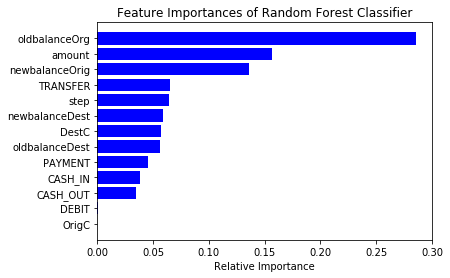

In [326]:
# check feature importance
importance=clf.feature_importances_
indices=np.argsort(importance)
features=df3.columns[0:13]

plt.title('Feature Importances of Random Forest Classifier')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)),  [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


in this random forest model, the top three features used to predict frauds are: customers' old balance, amount and customers'new balance.

In [335]:
# Average number of each features group by normal/frauds
df.groupby('isFraud').agg({'oldbalanceOrg':[('Average amount of oldbalanceOrg','mean')]\
          ,'newbalanceOrig':[('Average amount of  newbalanceOrig','mean')], \
                           'amount':[('Average amount','mean')] })

,oldbalanceOrg,newbalanceOrig,amount
,Average amount of oldbalanceOrg,Average amount of newbalanceOrig,Average amount
isFraud,,,
0,8.328287e+05,855970.228109,1.781970e+05
1,1.649668e+06,192392.631836,1.467967e+06


Text(0.5,1,'Customers old balance Distribution for Frauds')

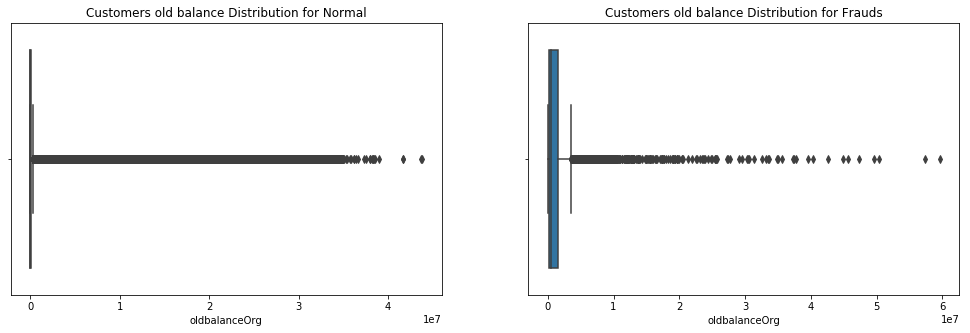

In [331]:
fig, axes=plt.subplots(1,2, figsize=[17,5])
sns.boxplot(df[df['isFraud']==0]['oldbalanceOrg'], ax=axes[0])
axes[0].set_title('Customers old balance Distribution for Normal')
sns.boxplot(df[df['isFraud']==1]['oldbalanceOrg'], ax=axes[1])
axes[1].set_title('Customers old balance Distribution for Frauds')

Text(0.5,1,'Amount($) Distribution for Frauds')

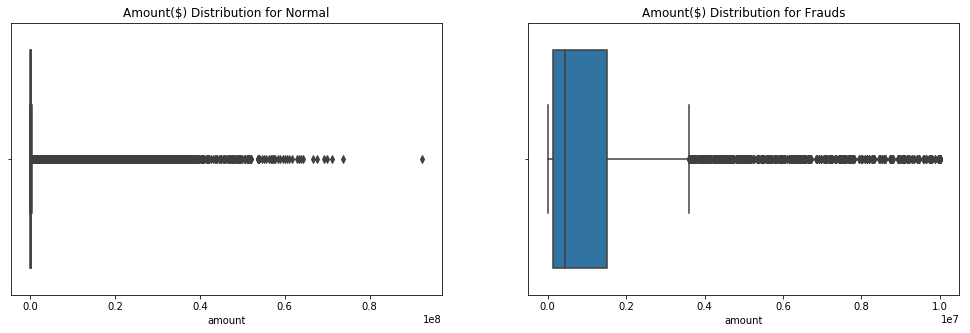

In [332]:
fig, axes=plt.subplots(1,2, figsize=[17,5])
sns.boxplot(df[df['isFraud']==0]['amount'], ax=axes[0])
axes[0].set_title('Amount($) Distribution for Normal')
sns.boxplot(df[df['isFraud']==1]['amount'], ax=axes[1])
axes[1].set_title('Amount($) Distribution for Frauds')

Text(0.5,1,'Customers New Balance DIstribution for Frauds')

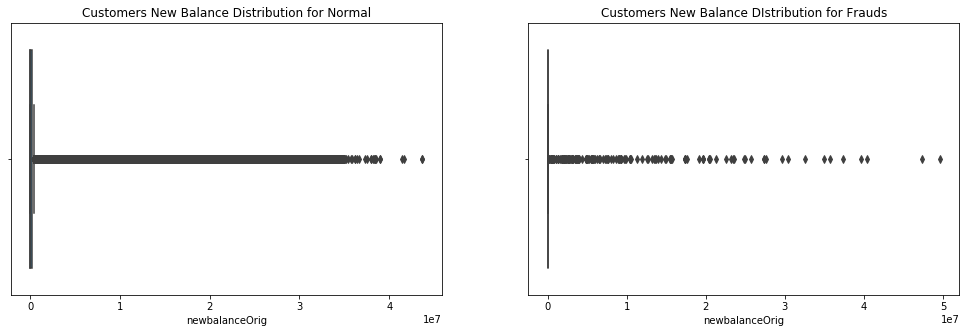

In [333]:
fig, axes=plt.subplots(1,2, figsize=[17,5])
sns.boxplot(df[df['isFraud']==0]['newbalanceOrig'], ax=axes[0])
axes[0].set_title('Customers New Balance Distribution for Normal')
sns.boxplot(df[df['isFraud']==1]['newbalanceOrig'], ax=axes[1])
axes[1].set_title('Customers New Balance DIstribution for Frauds')

Based on distribution and average level of these three features,  most of the transaction for frauds have larger customers’ old balance / amount each transaction compared to the normal transactions especially,  which is making sense. We can know that usually frauds are transferring or cash-out large amount of money from account with more money.


## 4. Summary:

##### 1.Overview
There are 6362620 non-null records in dataset, 8231 records are frauds which is 0.13% of all the records,  and only 16 flagged frauds. 

There are five types of transactions: cash-out, payment, cash-in, transfer,  debit. 

The whole time range is from step 1 to 743, within one month. Here I assume  step 1 is the 0 am on the first day. And I created day/week columns according to step and based on this logic 


##### 2.Exploratory Analysis Take-away

a. Daily/weekly trend of number of transactions

Within this month, the very beginning and the second week got much larger number of transactions, frauds happened on the first four weeks more often, most of flagged frauds happen on the last two weeks.

Last two weeks have higher frauds rate(number of frauds/number of transactions). On the last day, almost all the transactions are frauds. 

Basically, the total number of transactions is trending down but the fraud rate is trending up.


b. Daily/weekly trend of amount in local currency for transactions 


It’s very abnormal the last day got so high average amount per transaction but not many of total amount compared to the rest of the days in this month. then I found that all the 272 transactions on the last day are frauds, 3 of them are flagged frauds, and the average amount($) is about 164,7000 which is very high, about 10 times the average amount on other days. So first we need to check if the data is accurate or data logging process got wrong.  Second, we can check if those frauds happening in any certain type of device(android/ios) and customer/recipients’ country/city, to see if there's any hacker attach or technical issue happening on certain device or region.



d. Analysis by type and time
Cash-out and payment are the two most frequent type, while cash-out and transfer are the two types which got the greatest amount.

Transfer and cash-out have around 900 times of frauds each week and the number of frauds is trending down week by week. Only transfer has several illegal frauds flagged each week.

Transfer got more than 4 times of fraud rate(number of frauds/number of transactions) than cash-out, and fraud rate went up in this month, same trend for flaggedfraud.

Although fraud is only a small part among all the transactions, its average amount per transaction is very huge, which is about 10 times of  the normal transaction, and the average of amount for illegal fraud is about 30 times the normal transaction. 



##### 3. Random Forest Classifier Modeling
I built random forest model to help predict frauds, which got 98% precision score and 78% recall score. 

Based on feature importance analysis, the top three features to decide frauds are: customers' old balance, amount and customers' new balance. 

Based on distribution and average level of these three features,  most of the transaction for frauds have larger customers’ old balance / amount each transaction compared to the normal transactions especially,  which is making sense. We can know that usually frauds are transferring or cash-out large amount of money from account with more money.



#####  4.possible additional data we need
I think we also need data like 1.customers’ country/region and recipient country/country, so that we know which country has higher fraud rate and frauds, and we can get this by tracking users IP address.   2. users’ mobile device id, android/ios/other, sometimes hacker attack or technical issue happens on certain type of device, so we can better analyze which device is more possible to get frauds.  
